In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import fiona
from shapely.geometry import Point, shape
from gisutils import df2shp, project
from pydrograph import Nwis

### instantiate an NWIS object using a polygon shapefile of the study area
* `bbox.shp` is in UTM 83 zone 15 N
* pydrograph will automatically reproject the extent to GCS NAD83 by default (EPSG: 4269), which is the typical GCS used by NWIS. Alternatively, the NAD27 datum can be used (EPSG: 4267) by specifying `datum=NAD27` to the `NWIS()` constructor.

In [2]:
nwis = Nwis(extent='../data/bbox.shp')

reading extent from ../data/bbox.shp...
reprojecting extent from +init=epsg:26915 to +proj=longlat +ellps=GRS80 +datum=NAD83 +no_defs


/Users/aleaf/Documents/GitHub/pydrograph/pydrograph/nwis.py:163: FionaDeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.
  g = shape(shp.next()['geometry'])
/Users/aleaf/opt/anaconda3/envs/gis/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


### field measurements inventory table
* fetches inventory tables of all misc field measurements within the polygon

In [3]:
gw_field_sites = nwis.get_siteinfo('gwlevels')

getting site inventory for gwlevels...
url: http://nwis.waterdata.usgs.gov/usa/nwis/gwlevels?nw_longitude_va=-92.700&nw_latitude_va=46.800&se_longitude_va=-92.600&se_latitude_va=46.700&coordinate_format=decimal_degrees&group_key=NONE&format=sitefile_output&sitefile_output_format=rdb&column_name=site_no&column_name=station_nm&column_name=site_tp_cd&column_name=dec_lat_va&column_name=dec_long_va&column_name=coord_meth_cd&column_name=coord_acy_cd&column_name=coord_datum_cd&column_name=dec_coord_datum_cd&column_name=district_cd&column_name=state_cd&column_name=county_cd&column_name=country_cd&column_name=land_net_ds&column_name=map_nm&column_name=map_scale_fc&column_name=alt_va&column_name=alt_meth_cd&column_name=alt_acy_va&column_name=alt_datum_cd&column_name=huc_cd&column_name=basin_cd&column_name=topo_cd&column_name=data_types_cd&column_name=instruments_cd&column_name=construction_dt&column_name=inventory_dt&column_name=tz_cd&column_name=local_time_fg&column_name=reliability_cd&column_n

### daily values sites inventory table

In [4]:
gwdv_sites = nwis.get_siteinfo('gwdv')

getting site inventory for gwdv...
url: http://nwis.waterdata.usgs.gov/usa/nwis/dv?referred_module=gw&site_tp_cd=GW&nw_longitude_va=-92.700&nw_latitude_va=46.800&se_longitude_va=-92.600&se_latitude_va=46.700&coordinate_format=decimal_degrees&group_key=NONE&format=sitefile_output&sitefile_output_format=rdb&column_name=site_no&column_name=station_nm&column_name=site_tp_cd&column_name=dec_lat_va&column_name=dec_long_va&column_name=coord_meth_cd&column_name=coord_acy_cd&column_name=coord_datum_cd&column_name=dec_coord_datum_cd&column_name=district_cd&column_name=state_cd&column_name=county_cd&column_name=country_cd&column_name=land_net_ds&column_name=map_nm&column_name=map_scale_fc&column_name=alt_va&column_name=alt_meth_cd&column_name=alt_acy_va&column_name=alt_datum_cd&column_name=huc_cd&column_name=basin_cd&column_name=topo_cd&column_name=data_types_cd&column_name=instruments_cd&column_name=construction_dt&column_name=inventory_dt&column_name=tz_cd&column_name=local_time_fg&column_name=

### write shapefiles of the inventory tables
* `shapely Points` were created from the lat/lon coordinates when the tables were assembled; these are used to write the feature geometries for the shapefiles

In [5]:
df2shp(gwdv_sites, 'gw_dv_sites.shp', epsg=4269)
df2shp(gw_field_sites, 'gw_misc_sites.shp', epsg=4269)

writing gw_dv_sites.shp...
writing gw_misc_sites.shp...


### get daily values for a list of sites

In [6]:
sites = gwdv_sites.site_no.tolist()[0:2]
sites

[464222092403801, 464322092401401]

In [7]:
dvs = nwis.get_all_dvs(sites, 'gwlevels', start_date='1990-01-01')
dvs.keys()

http://waterservices.usgs.gov/nwis/dv/?format=rdb&sites=464222092403801&startDT=1990-01-01&parameterCd=72019
http://waterservices.usgs.gov/nwis/dv/?format=rdb&sites=464322092401401&startDT=1990-01-01&parameterCd=72019


dict_keys([464222092403801, 464322092401401])

In [8]:
dvs[464222092403801].head()

,agency_cd,site_no,datetime,74007_72019_00003,74007_72019_00003_cd
datetime,,,,,
2006-07-01,USGS,464222092403801,2006-07-01,8.48,A
2006-07-02,USGS,464222092403801,2006-07-02,8.51,A
2006-07-03,USGS,464222092403801,2006-07-03,8.54,A
2006-07-04,USGS,464222092403801,2006-07-04,8.56,A
2006-07-05,USGS,464222092403801,2006-07-05,8.59,A


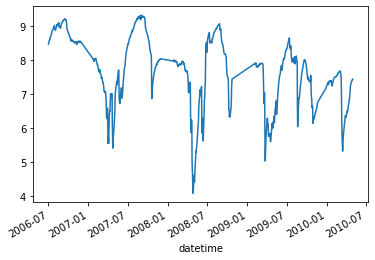

In [9]:
ax = dvs[464222092403801]['74007_72019_00003'].plot()

### get a single site

In [10]:
df = nwis.get_dvs(464322092401401, 'gwlevels')
df.head()

http://waterservices.usgs.gov/nwis/dv/?format=rdb&sites=464322092401401&startDT=1880-01-01&parameterCd=72019


,agency_cd,site_no,datetime,74012_72019_00003,74012_72019_00003_cd
datetime,,,,,
2006-07-01,USGS,464322092401401,2006-07-01,5.06,A
2006-07-02,USGS,464322092401401,2006-07-02,5.10,A
2006-07-03,USGS,464322092401401,2006-07-03,5.12,A
2006-07-04,USGS,464322092401401,2006-07-04,5.15,A
2006-07-05,USGS,464322092401401,2006-07-05,5.19,A


### just get the url for dvs for a site
(`start_date` is 1880-01-01 by default; `end_date` is `None` by default)

In [11]:
url = nwis.make_dv_url(464322092401401, parameter_code=72019)
url

http://waterservices.usgs.gov/nwis/dv/?format=rdb&sites=464322092401401&startDT=1880-01-01&parameterCd=72019


'http://waterservices.usgs.gov/nwis/dv/?format=rdb&sites=464322092401401&startDT=1880-01-01&parameterCd=72019'

## Fetch some miscellaneous measurements

In [12]:
sites = gw_field_sites.site_no.tolist()[:5]
sites

[464205092364101,
 464205092371801,
 464222092403801,
 464244092372701,
 464321092402301]

In [13]:
fm = nwis.get_all_measurements(sites, txt='gwlevels')

464205092364101
http://nwis.waterdata.usgs.gov/nwis/gwlevels?site_no=464205092364101&agency_cd=USGS&format=rdb
no data returned.
464205092371801
http://nwis.waterdata.usgs.gov/nwis/gwlevels?site_no=464205092371801&agency_cd=USGS&format=rdb
no data returned.
464222092403801
http://nwis.waterdata.usgs.gov/nwis/gwlevels?site_no=464222092403801&agency_cd=USGS&format=rdb
464244092372701
http://nwis.waterdata.usgs.gov/nwis/gwlevels?site_no=464244092372701&agency_cd=USGS&format=rdb
no data returned.
464321092402301
http://nwis.waterdata.usgs.gov/nwis/gwlevels?site_no=464321092402301&agency_cd=USGS&format=rdb


In [14]:
fm.head()

agency_cd          site_no site_tp_cd      lev_dt  \
site_no         datetime                                                       
464222092403801 2006-06-01      USGS  464222092403801         GW  2006-06-01   
                2006-06-23      USGS  464222092403801         GW  2006-06-23   
                2006-06-30      USGS  464222092403801         GW  2006-06-30   
                2006-07-21      USGS  464222092403801         GW  2006-07-21   
                2006-08-31      USGS  464222092403801         GW  2006-08-31   

                           lev_tm lev_tz_cd  lev_va  sl_lev_va  sl_datum_cd  \
site_no         datetime                                                      
464222092403801 2006-06-01  15:34       CDT    7.59        NaN          NaN   
                2006-06-23  07:58       CDT    8.30        NaN          NaN   
                2006-06-30  12:37       CDT    8.46        NaN          NaN   
                2006-07-21  07:34       CDT    8.90        NaN          NaN   
                2006-08-31  10:09       CDT    9.09        NaN          NaN   

                            lev_status_cd lev_agency_cd lev_dt_acy_cd  \
site_no         datetime                                                
464222092403801 2006-06-01            NaN          USGS             m   
                2006-06-23            NaN          USGS             m   
                2006-06-30            NaN          USGS             m   
                2006-07-21            NaN          USGS             m   
                2006-08-31            NaN          USGS             m   

                            lev_acy_cd lev_src_cd lev_meth_cd lev_age_cd  \
site_no         datetime                                                   
464222092403801 2006-06-01           2          S           V          A   
                2006-06-23           2          S           V          A   
                2006-06-30           2          S           V          A   
                2006-07-21           2          S           V          A   
                2006-08-31           2          S           V          A   

                           measurement_dt  
site_no         datetime                   
464222092403801 2006-06-01     2006-06-01  
                2006-06-23     2006-06-23  
                2006-06-30     2006-06-30  
                2006-07-21     2006-07-21  
                2006-08-31     2006-08-31